In [1]:
# Импорт библиотек
import shap
import warnings
import missingno as msno
from catboost import CatBoostRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit
from my_functions import *

shap.initjs()
%matplotlib inline
warnings.filterwarnings('ignore')

## Квартальные факторы

In [2]:
quarter_factors = pd.read_csv('квартальные.csv', ';')

In [3]:
quarter_factors.head(1)

,Unnamed: 0,"Курс $/евро (доллары за евро), среднее за период","Реальный ВВП в ценах 2016г, млрд. руб.","Реальный ВВП, % гг","Номинальный ВВП в текущих ценах, млрд. руб.","Номинальный ВВП, % гг","Курс руб./$ (рубли за доллар), среднее за период","Курс руб./€ (рубли за евро), среднее за период","Торговый баланс товаров и услуг, $ млрд. за период","Безработица, % среднее за период",...,"Экспорт товаров и услуг, % от ВВП","Экспорт товаров и услуг в ценах 2016г, % гг*","Импорт товаров и услуг в ценах 2016г, млрд. руб.","Импорт товаров и услуг, % от ВВП","Импорт товаров и услуг в ценах 2016г, % гг*","USDLibor6M, % среднее за период","EURibor3M, % среднее за период","Ключевая ставка ЦБ, % на конец периода (до 2013г 1 недельное репо)","Золотовалютные резервы, млрд. долл. на конец периода","Реальный ВВП в ценах 2016г с учетом сезонности, млрд. руб."
0,Q1-2010,1.383867,17851.0,0.041,10736.8,0.199307,29.9,41.39,41.3984,0.086667,...,0.262047,0.189009,3764.5,0.210885,0.119987,0.003993,0.006623,0.0525,447.4416,NaN


Обозначение кварталов сделаем индексами и приведем к типу "period" (чтобы можно было применить в дальнейшем resample и merge):

In [4]:
quarter_factors['Unnamed: 0'][-1:]

41    Q2-2020
Name: Unnamed: 0, dtype: object

In [5]:
quarter_factors.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
idx = pd.period_range(start='2010-01-01', end='2020-06-01', freq='Q')
idx

PeriodIndex(['2010Q1', '2010Q2', '2010Q3', '2010Q4', '2011Q1', '2011Q2',
             '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4',
             '2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2',
             '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4',
             '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2',
             '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
             '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2'],
            dtype='period[Q-DEC]')

In [7]:
quarter_factors.set_index(idx, inplace=True)

In [8]:
# Краткая справка по датасету
ds = [['Признак', 'тип данных', '% заполнения', 'диапазон значений', 'кол-во уникальных значений']]
columns_list = quarter_factors.columns.to_list()
for col in columns_list:
    index = columns_list.index(col)
    ds = ds_inf(ds, col, index + 1, quarter_factors)
    
display(HTML(tabulate(ds[1:], headers = ds[0], tablefmt = 'html', showindex = "always")))

quarter_factors.info(verbose = False)

,Признак,тип данных,% заполнения,диапазон значений,кол-во уникальных значений
0,"Курс $/евро (доллары за евро), среднее за период",float64,100,1.065866667 - 1.439933333,42
1,"Реальный ВВП в ценах 2016г, млрд. руб.",float64,98,17851.0 - 25155.0,41
2,"Реальный ВВП, % гг",float64,98,-0.031 - 0.057,37
3,"Номинальный ВВП в текущих ценах, млрд. руб.",float64,98,10736.8 - 29815.6,41
4,"Номинальный ВВП, % гг",float64,98,0.014949007 - 0.22492103,41
5,"Курс руб./$ (рубли за доллар), среднее за период",float64,100,27.99 - 74.59,42
6,"Курс руб./€ (рубли за евро), среднее за период",float64,100,38.56 - 82.32,42
7,"Торговый баланс товаров и услуг, $ млрд. за период",float64,100,10.6893 - 50.7453,42
8,"Безработица, % среднее за период",float64,100,0.044333333 - 0.086666667,33
9,"Денежная масса (М2), млрд. руб. на конец периода",float64,100,15639.4 - 54392.6,42


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 42 entries, 2010Q1 to 2020Q2
Freq: Q-DEC
Columns: 46 entries, Курс $/евро (доллары за евро), среднее за период to Реальный ВВП в ценах 2016г  с учетом сезонности, млрд. руб.
dtypes: float64(46)
memory usage: 15.4 KB


Делаем resample по месяцам, чтобы была одинаковая грануляция данных в двух таблицах для дальнейшей операции merge:

In [9]:
quarter_factors_by_months = quarter_factors.resample('M', convention='end').asfreq()
quarter_factors_by_months.reset_index(drop=False, inplace=True)
quarter_factors_by_months.rename(columns={"index": "Месяц"}, inplace=True)

In [10]:
quarter_factors_by_months.head()

,Месяц,"Курс $/евро (доллары за евро), среднее за период","Реальный ВВП в ценах 2016г, млрд. руб.","Реальный ВВП, % гг","Номинальный ВВП в текущих ценах, млрд. руб.","Номинальный ВВП, % гг","Курс руб./$ (рубли за доллар), среднее за период","Курс руб./€ (рубли за евро), среднее за период","Торговый баланс товаров и услуг, $ млрд. за период","Безработица, % среднее за период",...,"Экспорт товаров и услуг, % от ВВП","Экспорт товаров и услуг в ценах 2016г, % гг*","Импорт товаров и услуг в ценах 2016г, млрд. руб.","Импорт товаров и услуг, % от ВВП","Импорт товаров и услуг в ценах 2016г, % гг*","USDLibor6M, % среднее за период","EURibor3M, % среднее за период","Ключевая ставка ЦБ, % на конец периода (до 2013г 1 недельное репо)","Золотовалютные резервы, млрд. долл. на конец периода","Реальный ВВП в ценах 2016г с учетом сезонности, млрд. руб."
0,2010-03,1.383867,17851.0,0.041,10736.8,0.199307,29.90,41.39,41.3984,0.086667,...,0.262047,0.189009,3764.5,0.210885,0.119987,0.003993,0.006623,0.0525,447.4416,NaN
1,2010-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-06,1.273433,18949.3,0.050,11790.7,0.187358,30.23,38.56,32.7857,0.073333,...,0.239687,0.043995,4944.1,0.260912,0.223000,0.006290,0.006867,0.0500,461.2007,NaN
4,2010-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Месячные факторы

In [11]:
month_factors = pd.read_csv('месячные.csv',';')

In [12]:
month_factors.head(1)

,Unnamed: 0,Рынок РФ. Объем выдач рублевых жилищных кредитов,"Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца.","Инфляция (ИПЦ), % гг на конец периода","Инфляция (ИПЦ), % мм на конец периода","Денежная масса (М2), % гг среднее за период","Денежный агрегат (М0), % гг среднее за период","Рост промышленного производства, % гг среднее за период","Рост промышленного производства, % мм среднее за период (NSA)",Индекс промышленного проиводства (NSA 2015=100),...,"Курс руб./$ (рубли за доллар), среднее за период","Курс руб./$ (рубли за доллар), на конец периода","Курс руб./евро, среднее за период","Курс руб./евро, на конец периода","Курс долл./евро (доллар за евро), среднее за период","Номинальная среднемесячная з/п, руб. среднее за период",Профицит/дефицит консолидированного бюджета (накопленным итогом),Профицит/дефицит федерального бюджета (накопленным итогом),Расходы на национальную оборону (накопленным итогом),"Золотовалютные резервы, млрд. долл. на конец периода"
0,Jan-2010,9.351000e+09,NaN,0.0802,0.0164,0.304,0.169228,0.085,-0.146,77.6,...,29.77,30.36,42.56,42.58,1.4266,18938.0,395.98,87.107,27.12,436.2669


In [13]:
month_factors.tail(1)

,Unnamed: 0,Рынок РФ. Объем выдач рублевых жилищных кредитов,"Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца.","Инфляция (ИПЦ), % гг на конец периода","Инфляция (ИПЦ), % мм на конец периода","Денежная масса (М2), % гг среднее за период","Денежный агрегат (М0), % гг среднее за период","Рост промышленного производства, % гг среднее за период","Рост промышленного производства, % мм среднее за период (NSA)",Индекс промышленного проиводства (NSA 2015=100),...,"Курс руб./$ (рубли за доллар), среднее за период","Курс руб./$ (рубли за доллар), на конец периода","Курс руб./евро, среднее за период","Курс руб./евро, на конец периода","Курс долл./евро (доллар за евро), среднее за период","Номинальная среднемесячная з/п, руб. среднее за период",Профицит/дефицит консолидированного бюджета (накопленным итогом),Профицит/дефицит федерального бюджета (накопленным итогом),Расходы на национальную оборону (накопленным итогом),"Золотовалютные резервы, млрд. долл. на конец периода"
126,Jul-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,71.29,73.36,81.49,86.25,NaN,NaN,NaN,NaN,NaN,NaN


Также приведем дату к типу "period":

In [14]:
month_factors.rename(columns={"Unnamed: 0": "Месяц"}, inplace=True)
month_factors['Месяц'] = pd.period_range(start='2010-01-01', end='2020-07-01', freq='M')

In [15]:
ds = [['Признак', 'тип данных', '% заполнения', 'диапазон значений', 'кол-во уникальных значений']]
columns_list = month_factors.columns.to_list()
for col in columns_list:
    index = columns_list.index(col)
    ds = ds_inf(ds, col, index + 1, month_factors)
    
display(HTML(tabulate(ds[1:], headers = ds[0], tablefmt = 'html', showindex = "always")))

month_factors.info(verbose = False)

,Признак,тип данных,% заполнения,диапазон значений,кол-во уникальных значений
0,Месяц,period[M],100,2010-01 - 2020-07,127
1,Рынок РФ. Объем выдач рублевых жилищных кредитов,float64,91,9351000000.0 - 341265000000.0,115
2,"Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца.",float64,59,8.62 - 14.71,69
3,"Инфляция (ИПЦ), % гг на конец периода",float64,99,0.0218 - 0.1692,120
4,"Инфляция (ИПЦ), % мм на конец периода",float64,99,-0.0054 - 0.0385,81
5,"Денежная масса (М2), % гг среднее за период",float64,99,0.015 - 0.363,98
6,"Денежный агрегат (М0), % гг среднее за период",float64,99,-0.030807696 - 0.298054854,126
7,"Рост промышленного производства, % гг среднее за период",float64,99,-0.096 - 0.093,69
8,"Рост промышленного производства, % мм среднее за период (NSA)",float64,99,-0.222 - 0.135,90
9,Индекс промышленного проиводства (NSA 2015=100),float64,99,77.6 - 121.0,108


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Columns: 34 entries, Месяц to Золотовалютные резервы, млрд. долл. на конец периода
dtypes: float64(33), period[M](1)
memory usage: 33.9 KB


In [16]:
# парные корреляции между всеми переменными
numerical_features = month_factors.select_dtypes(include=[np.number])
correlations = numerical_features.corr()
correlations = pd.DataFrame(correlations.unstack(), columns=['corr'])
correlations['corr_abs'] = correlations['corr'].abs()
correlations = correlations[correlations.corr_abs != 1]
correlations = correlations.drop_duplicates()
correlations.index.set_names(['level_0', 'level_1'], inplace=True)
# correlations = correlations.sort_values(['level_0','corr_abs'], ascending=[True,False])
correlations = correlations.sort_values(['corr_abs'], ascending=[False])
correlations

,,corr,corr_abs
level_0,level_1,,
"Денежная масса (М2), % гг среднее за период","Рост M2, %гг",0.999994,0.999994
"Курс руб./$ (рубли за доллар), среднее за период","Курс руб./$ (рубли за доллар), на конец периода",0.996476,0.996476
"Курс руб./евро, среднее за период","Курс руб./евро, на конец периода",0.995082,0.995082
"Курс руб./$ (рубли за доллар), среднее за период","Курс руб./евро, среднее за период",0.990269,0.990269
Бескупонная 3-летняя ОФЗ,Бескупонная 5-летняя ОФЗ,0.990195,0.990195
...,...,...,...
"Рост промышленного производства, % гг среднее за период","Рост реальных располагаемых денежных доходов населения, % мм",0.002599,0.002599
"Рост реальных располагаемых денежных доходов населения, % гг","Рост розничной торговли, %мм (на конец)",-0.002312,0.002312
"Рост реальных располагаемых денежных доходов населения, % мм","Курс руб./евро, среднее за период",0.001956,0.001956


"Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца"

"Ключевая ставка ЦБ, % на конец периода"

Высокая корреляция между 2-мя этими ставками: 0.78. Поэтому для модели разумно выбрать какую-то одну.

In [17]:
# корреляции факторов c целевой переменной
df_corr = month_factors.drop(['Рынок РФ. Объем выдач рублевых жилищных кредитов'], axis=1). \
          corrwith(month_factors['Рынок РФ. Объем выдач рублевых жилищных кредитов']).reset_index(). \
          rename(columns={'index':'feature', 0:'corr'})
df_corr['corr_abs'] = df_corr['corr'].abs()
df_corr = df_corr.sort_values('corr_abs', ascending=False)
df_corr

,feature,corr,corr_abs
27,"Номинальная среднемесячная з/п, руб. среднее з...",0.888476,0.888476
0,Рынок РФ. Средневзвешенная ставка по жилищным ...,-0.833905,0.833905
7,Индекс промышленного проиводства (NSA 2015=100),0.810973,0.810973
16,"Безработица, % (SA)",-0.775914,0.775914
25,"Курс руб./евро, на конец периода",0.662843,0.662843
24,"Курс руб./евро, среднее за период",0.656472,0.656472
23,"Курс руб./$ (рубли за доллар), на конец периода",0.609286,0.609286
22,"Курс руб./$ (рубли за доллар), среднее за период",0.605946,0.605946
17,"Рост M2, %гг",-0.603128,0.603128
3,"Денежная масса (М2), % гг среднее за период",-0.602983,0.602983


По "Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца" сильная корреляция с целевой переменной: 0.83, % заполнения: 59.

По "Ключевая ставка ЦБ, % на конец периода" слабая корреляция с целевой переменной: 0.21, процент заполнения: 100.


Сохраним отдельно факторы с высокой корреляцией:

In [18]:
top_features = df_corr[:4].feature.values.tolist()

Попробуем заполнить пропуски по "Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца" и посмотреть снова на ее корреляцию с целевой переменной:

array([[<AxesSubplot:title={'center':'Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. '}>]],
      dtype=object)

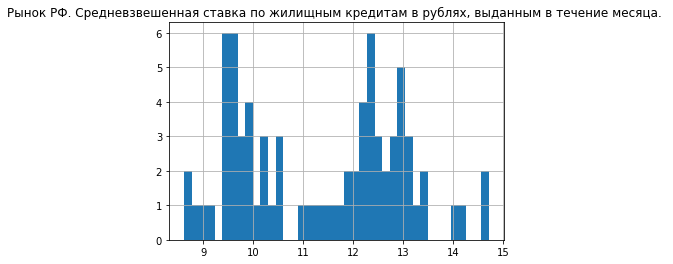

In [19]:
# Пропуски нужно стараться заполнить так, чтобы минимально изменить исходное распределение
month_factors[['Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. ']].hist(bins=40)

<AxesSubplot:>

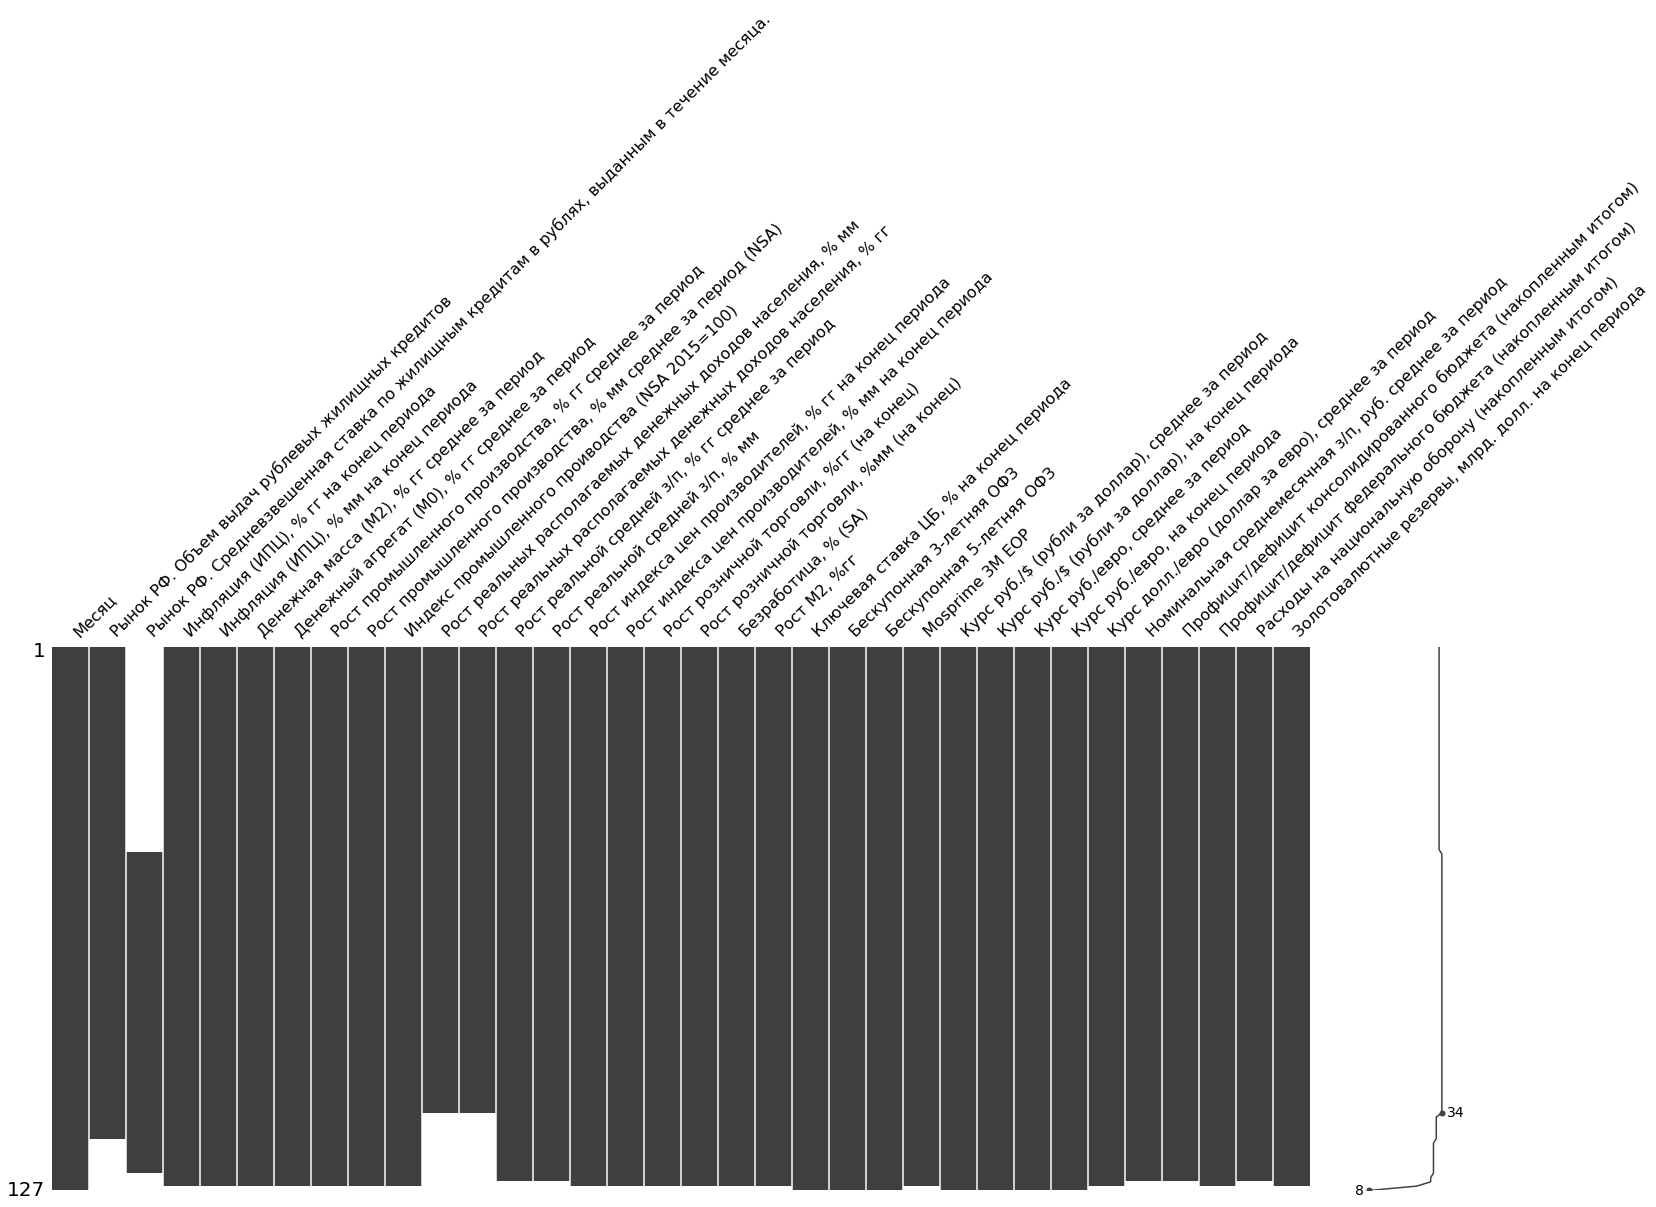

In [20]:
msno.matrix(month_factors)

Здесь видно, что большая часть данных отсутствует в самом начале, что осложняет процесс корректного заполнения пропусков.

Также здесь нельзя удалить пропуски в силу небольшого размера датасета и большого кол-ва пропусков.

In [21]:
# Данный метод на некоторых наборах данных может быть точнее среднего/медианы или константы, 
# учитывает корреляцию между параметрами (как раз здесь поможет высокая корреляция двух ставок).
knn_imputer = KNNImputer(n_neighbors=5, weights="distance")

In [22]:
month_factors_copy = month_factors.drop(['Месяц'], axis=1)
month_factors_copy = pd.DataFrame(knn_imputer.fit_transform(month_factors_copy), columns = month_factors_copy.columns)

array([[<AxesSubplot:title={'center':'Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. '}>]],
      dtype=object)

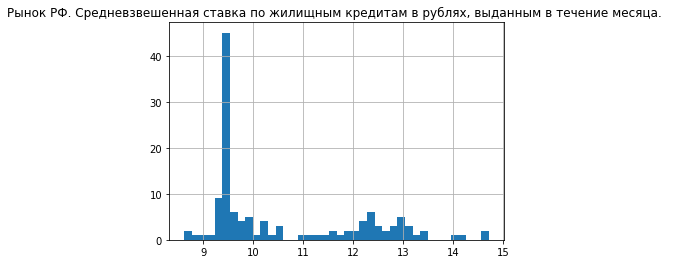

In [23]:
month_factors_copy[["Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. "]].hist(bins=40)

Здесь видно, что KNNImputer заполнил большинство пропусков одним и тем же числом.

In [24]:
month_factors_copy['Рынок РФ. Объем выдач рублевых жилищных кредитов'].\
corr(month_factors_copy["Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. "])

-0.10315341842313262

Наблюдаем резкое падение корреляции с высокой 0.83 до низкой 0.1

In [25]:
month_factors_copy['Ключевая ставка ЦБ, % на конец периода'].\
corr(month_factors_copy["Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. "])

0.8517767734677423

Высокая корреляция между ставками сохранилась и здесь уже 'Ключевая ставка ЦБ, % на конец периода' как фича выглядит предпочтительнее для линейной регрессии.

Для интереса можно посмотреть на то, какая корреляция будет, если заменить пропуски на средние.

In [26]:
mean_imputer = SimpleImputer(strategy='mean')

In [27]:
month_factors_copy = month_factors.drop(['Месяц'], axis=1)
month_factors_copy = pd.DataFrame(mean_imputer.fit_transform(month_factors_copy), columns = month_factors_copy.columns)

array([[<AxesSubplot:title={'center':'Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. '}>]],
      dtype=object)

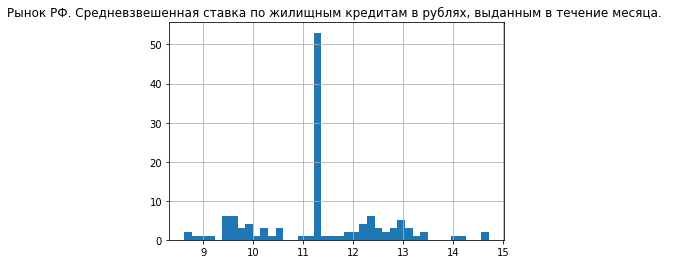

In [28]:
month_factors_copy[["Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. "]].hist(bins=40)

In [29]:
month_factors_copy['Рынок РФ. Объем выдач рублевых жилищных кредитов'].\
corr(month_factors_copy["Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. "])

-0.45086279100618143

In [30]:
month_factors_copy['Ключевая ставка ЦБ, % на конец периода'].\
corr(month_factors_copy["Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. "])

0.548396234265596

Здесь умеренный показатель корреляции с целевой переменной, но взаимосвязь с 'Ключевая ставка ЦБ, % на конец периода' меньше.

В обоих случаях у распределений средневзвешенной ставки появились пики. 

Учитывая эти показатели, модель зависимости целевой переменной от ставки с высокой предсказательной силой не построишь.

Посмотрим на распределение целевой переменной:

array([[<AxesSubplot:title={'center':'Рынок РФ. Объем выдач рублевых жилищных кредитов'}>]],
      dtype=object)

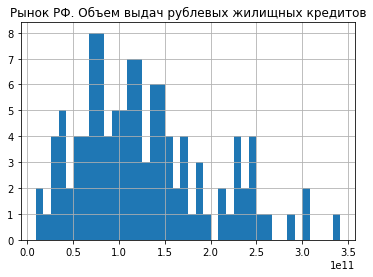

In [31]:
month_factors[['Рынок РФ. Объем выдач рублевых жилищных кредитов']].hist(bins=40)

Проверка на наличие выбросов в данных:

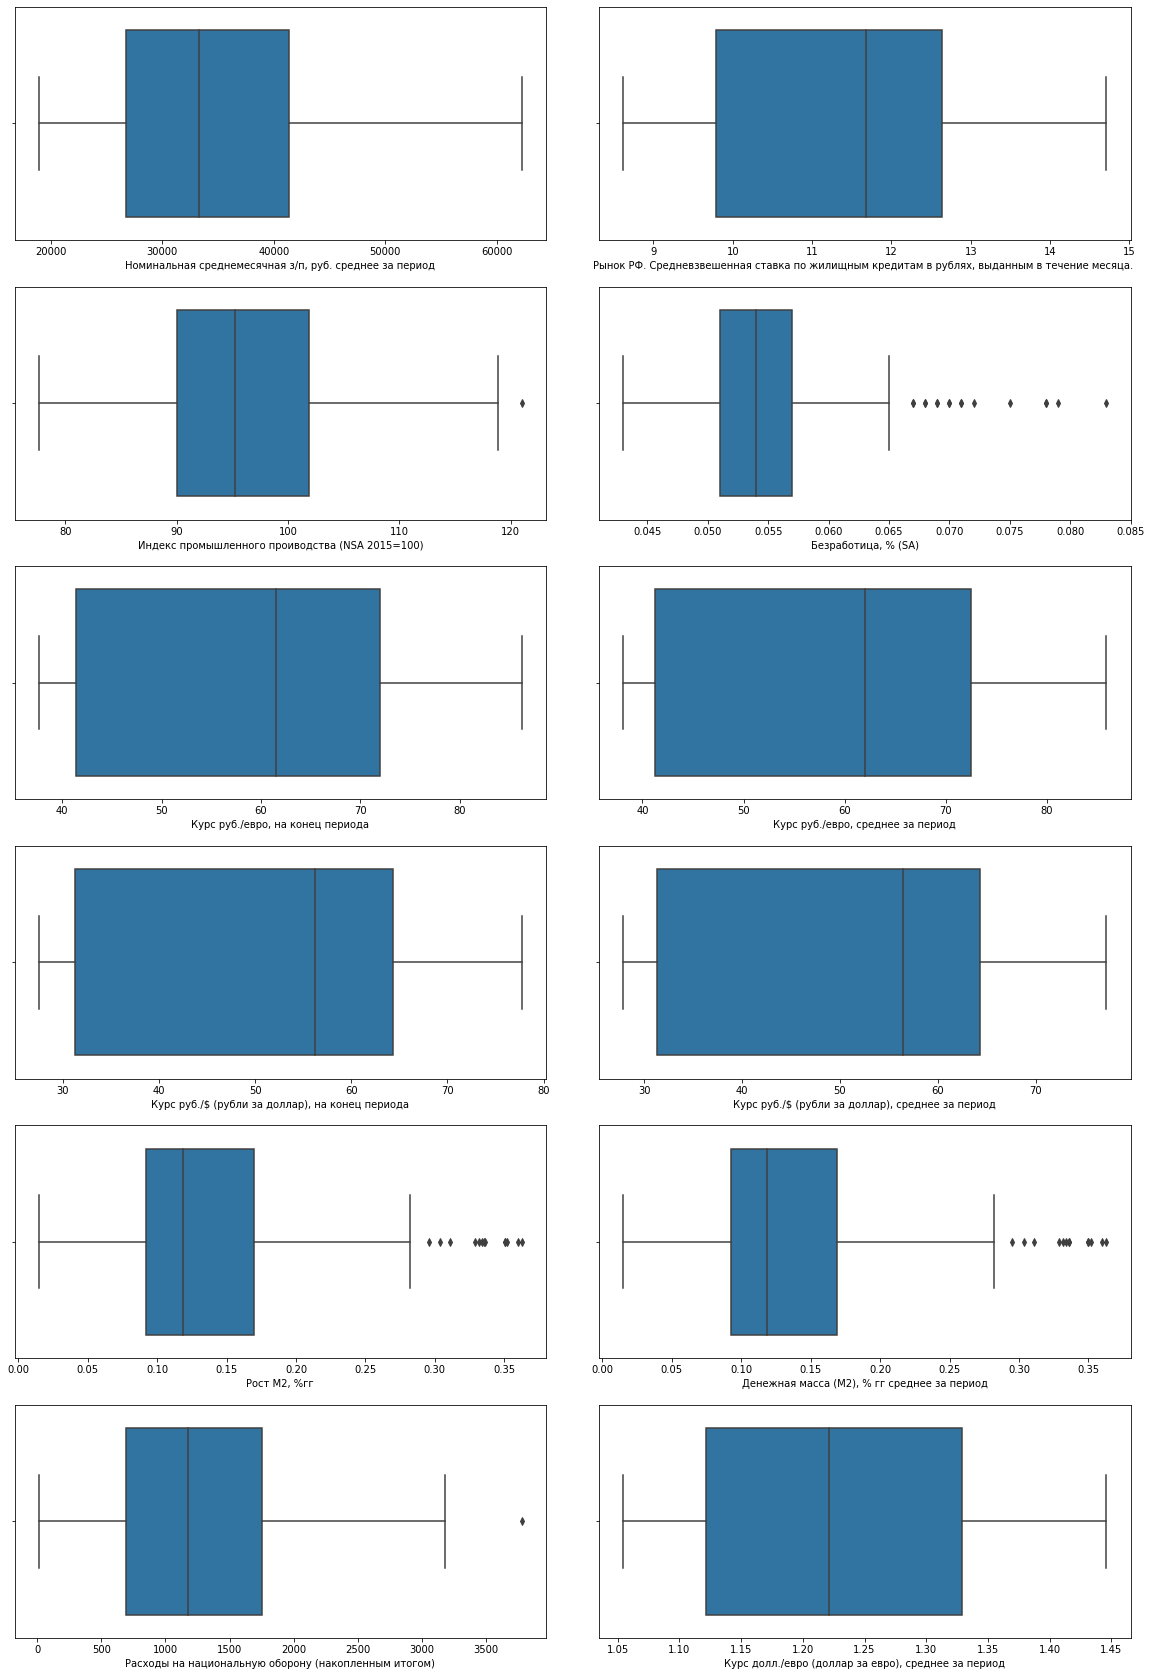

In [32]:
fig, ax = plt.subplots(6, 2, figsize = (20, 30))

for num, col in enumerate (df_corr.iloc[:12, [0]].values.ravel().tolist()):
    
    sns.boxplot(x = month_factors[col], ax = ax[num // 2, num % 2])
    
    plt.subplots_adjust(hspace = 0.2, wspace = 0.1)

<AxesSubplot:xlabel='Ключевая ставка ЦБ, % на конец периода'>

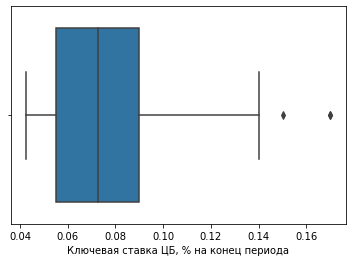

In [33]:
sns.boxplot(x = month_factors['Ключевая ставка ЦБ, % на конец периода'])

## Построим дерево по зависимости целевой переменной от ставки

In [34]:
X = month_factors[['Ключевая ставка ЦБ, % на конец периода']][:-12]
y = month_factors[['Рынок РФ. Объем выдач рублевых жилищных кредитов']][:-12]

In [35]:
%%time
dt = DecisionTreeRegressor()
parametrs = {'max_depth': range(1,10),
             'min_samples_split': range(2,10),
             'min_samples_leaf': range(1,10)}
search = GridSearchCV(dt, parametrs)

search.fit(X, y)

Wall time: 9.12 s


GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10)})

In [36]:
search.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 7}

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=False)

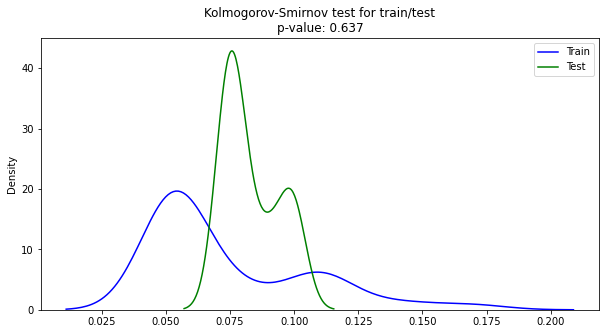

In [38]:
# Проверка распределений фичей на train'е и test'е на их совпадение
plot_Kolmogorov_Smirnov_test(X_train, X_test)

Видно, что распределения слишком различаются, поэтому нужно по другому разделить данные на train/test.

В sklearn для временных рядов есть специальная функция TimeSeriesSplit. Попробуем применить ее.

In [39]:
cv = TimeSeriesSplit(n_splits=20, test_size=2)
results = defaultdict(list)

for fold, (train_index, test_index) in enumerate(cv.split(X), 1):

    x_train, x_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]                 

    cv_model = DecisionTreeRegressor(**search.best_params_, random_state=1)
    cv_model.fit(x_train, y_train)

    prediction_tr = cv_model.predict(x_train)
    prediction = cv_model.predict(x_test)

    MAE_train = round(MAE(y_train, prediction_tr),3)        
    RMSE_train = round(MSE(y_train, prediction_tr, squared=False), 3)             
    R2_train = round(r2_score(y_train, prediction_tr),3)   

    MAE_test = round(MAE(y_test, prediction),3)        
    RMSE_test = round(MSE(y_test, prediction, squared=False), 3)
    R2_test = round(r2_score(y_test, prediction),3)     

    results['MAE train'].append(MAE_train)
    results['MAE test'].append(MAE_test)
    results['RMSE train'].append(RMSE_train)
    results['RMSE test'].append(RMSE_test)
    results['R2 train'].append(R2_train)
    results['R2 test'].append(R2_test)   

К выбранным метрикам были отнесены средняя абсолютная ошибка (MAE) и корень из среднеквадратической ошибки (RMSE).

MAE помогает оценить абсолютную ошибку – то, на сколько число в прогнозах разошлось с реальным числом. Погрешность измеряется в тех же единицах, что и значения целевой переменной.

RMSE используется для оценки ошибки в прогнозах. Погрешность измеряется в тех же единицах, что и значения целевой переменной.

Также добавлен коэффициент детерминации (R2) для того, чтобы оценить качество обученной модели.

In [40]:
MAE_train = round(np.mean(results['MAE train']), 3)
RMSE_train = round(np.mean(results['RMSE train']), 3)
R2_train = round(np.mean(results['R2 train']), 3)
MAE_test = round(np.mean(results['MAE test']), 3)
RMSE_test = round(np.mean(results['RMSE test']), 3)
R2_test = round(np.mean(results['R2 test']), 3)    

dict_ = {'MAE train'        :[MAE_train],
         'RMSE train'       :[RMSE_train],
         'R2 train'         :[R2_train],
         'MAE test'         :[MAE_test],
         'RMSE test'        :[RMSE_test],
         'R2 test'          :[R2_test]}

pd.DataFrame(dict_)

,MAE train,RMSE train,R2 train,MAE test,RMSE test,R2 test
0,2.045401e+10,2.863827e+10,0.688,3.761538e+10,4.043840e+10,-1243.704


Модель получилась неадекватной.

In [41]:
'''
Последовательно разбиваем всю выборку на 20 частей, затем каждую часть делим последовательно на train/test (70/30), 
обучение происходит 1 раз на собранных воедино 20 частях train
'''
X_train, X_test, y_train, y_test = custom_split(X=X, y=y, fold_num=20, train_size=0.7)

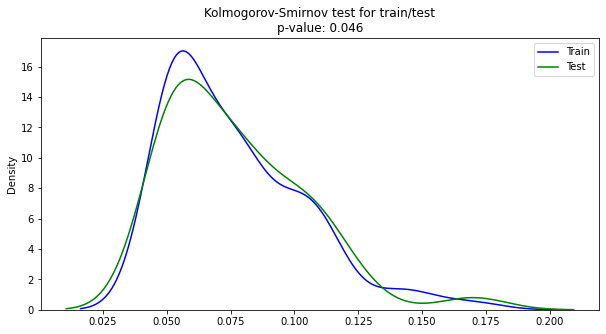

In [42]:
# Проверка распределений фичей на train'е и test'е на их совпадение
plot_Kolmogorov_Smirnov_test(X_train, X_test)

In [43]:
model = DecisionTreeRegressor(**search.best_params_, random_state=1)
model, dict_, prediction_tr, prediction = model_train(model, X_train, X_test, y_train, y_test)
pd.DataFrame(dict_)

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,"DecisionTreeRegressor(max_depth=5, min_samples...","[Ключевая ставка ЦБ, % на конец периода]",1,1.967307e+10,3.878654e+10,2.606983e+10,5.330638e+10,0.848,0.498


По R2 хорошо видно, что модель переобучена, что свойственно данному алгоритму.

[Text(1147.0, 1107.3333333333333, 'X[0] <= 0.065\nmse = 4.457135710259068e+21\nsamples = 77\nvalue = 119342974025.974'),
 Text(496.0, 906.0, 'X[0] <= 0.054\nmse = 1.2249577127794107e+21\nsamples = 34\nvalue = 70620500000.0'),
 Text(248.0, 704.6666666666666, 'X[0] <= 0.051\nmse = 5.2545640646913556e+20\nsamples = 18\nvalue = 54744444444.444'),
 Text(124.0, 503.33333333333326, 'mse = 4.8718602799999885e+19\nsamples = 5\nvalue = 35599000000.0'),
 Text(372.0, 503.33333333333326, 'mse = 5.136140003786983e+20\nsamples = 13\nvalue = 62108076923.077'),
 Text(744.0, 704.6666666666666, 'X[0] <= 0.056\nmse = 1.4093417070585918e+21\nsamples = 16\nvalue = 88481062500.0'),
 Text(620.0, 503.33333333333326, 'mse = 6.895908972091868e+20\nsamples = 14\nvalue = 99197071428.571'),
 Text(868.0, 503.33333333333326, 'mse = 1.6957924000006046e+19\nsamples = 2\nvalue = 13469000000.0'),
 Text(1798.0, 906.0, 'X[0] <= 0.094\nmse = 3.651634231736089e+21\nsamples = 43\nvalue = 157867720930.233'),
 Text(1364.0, 704.

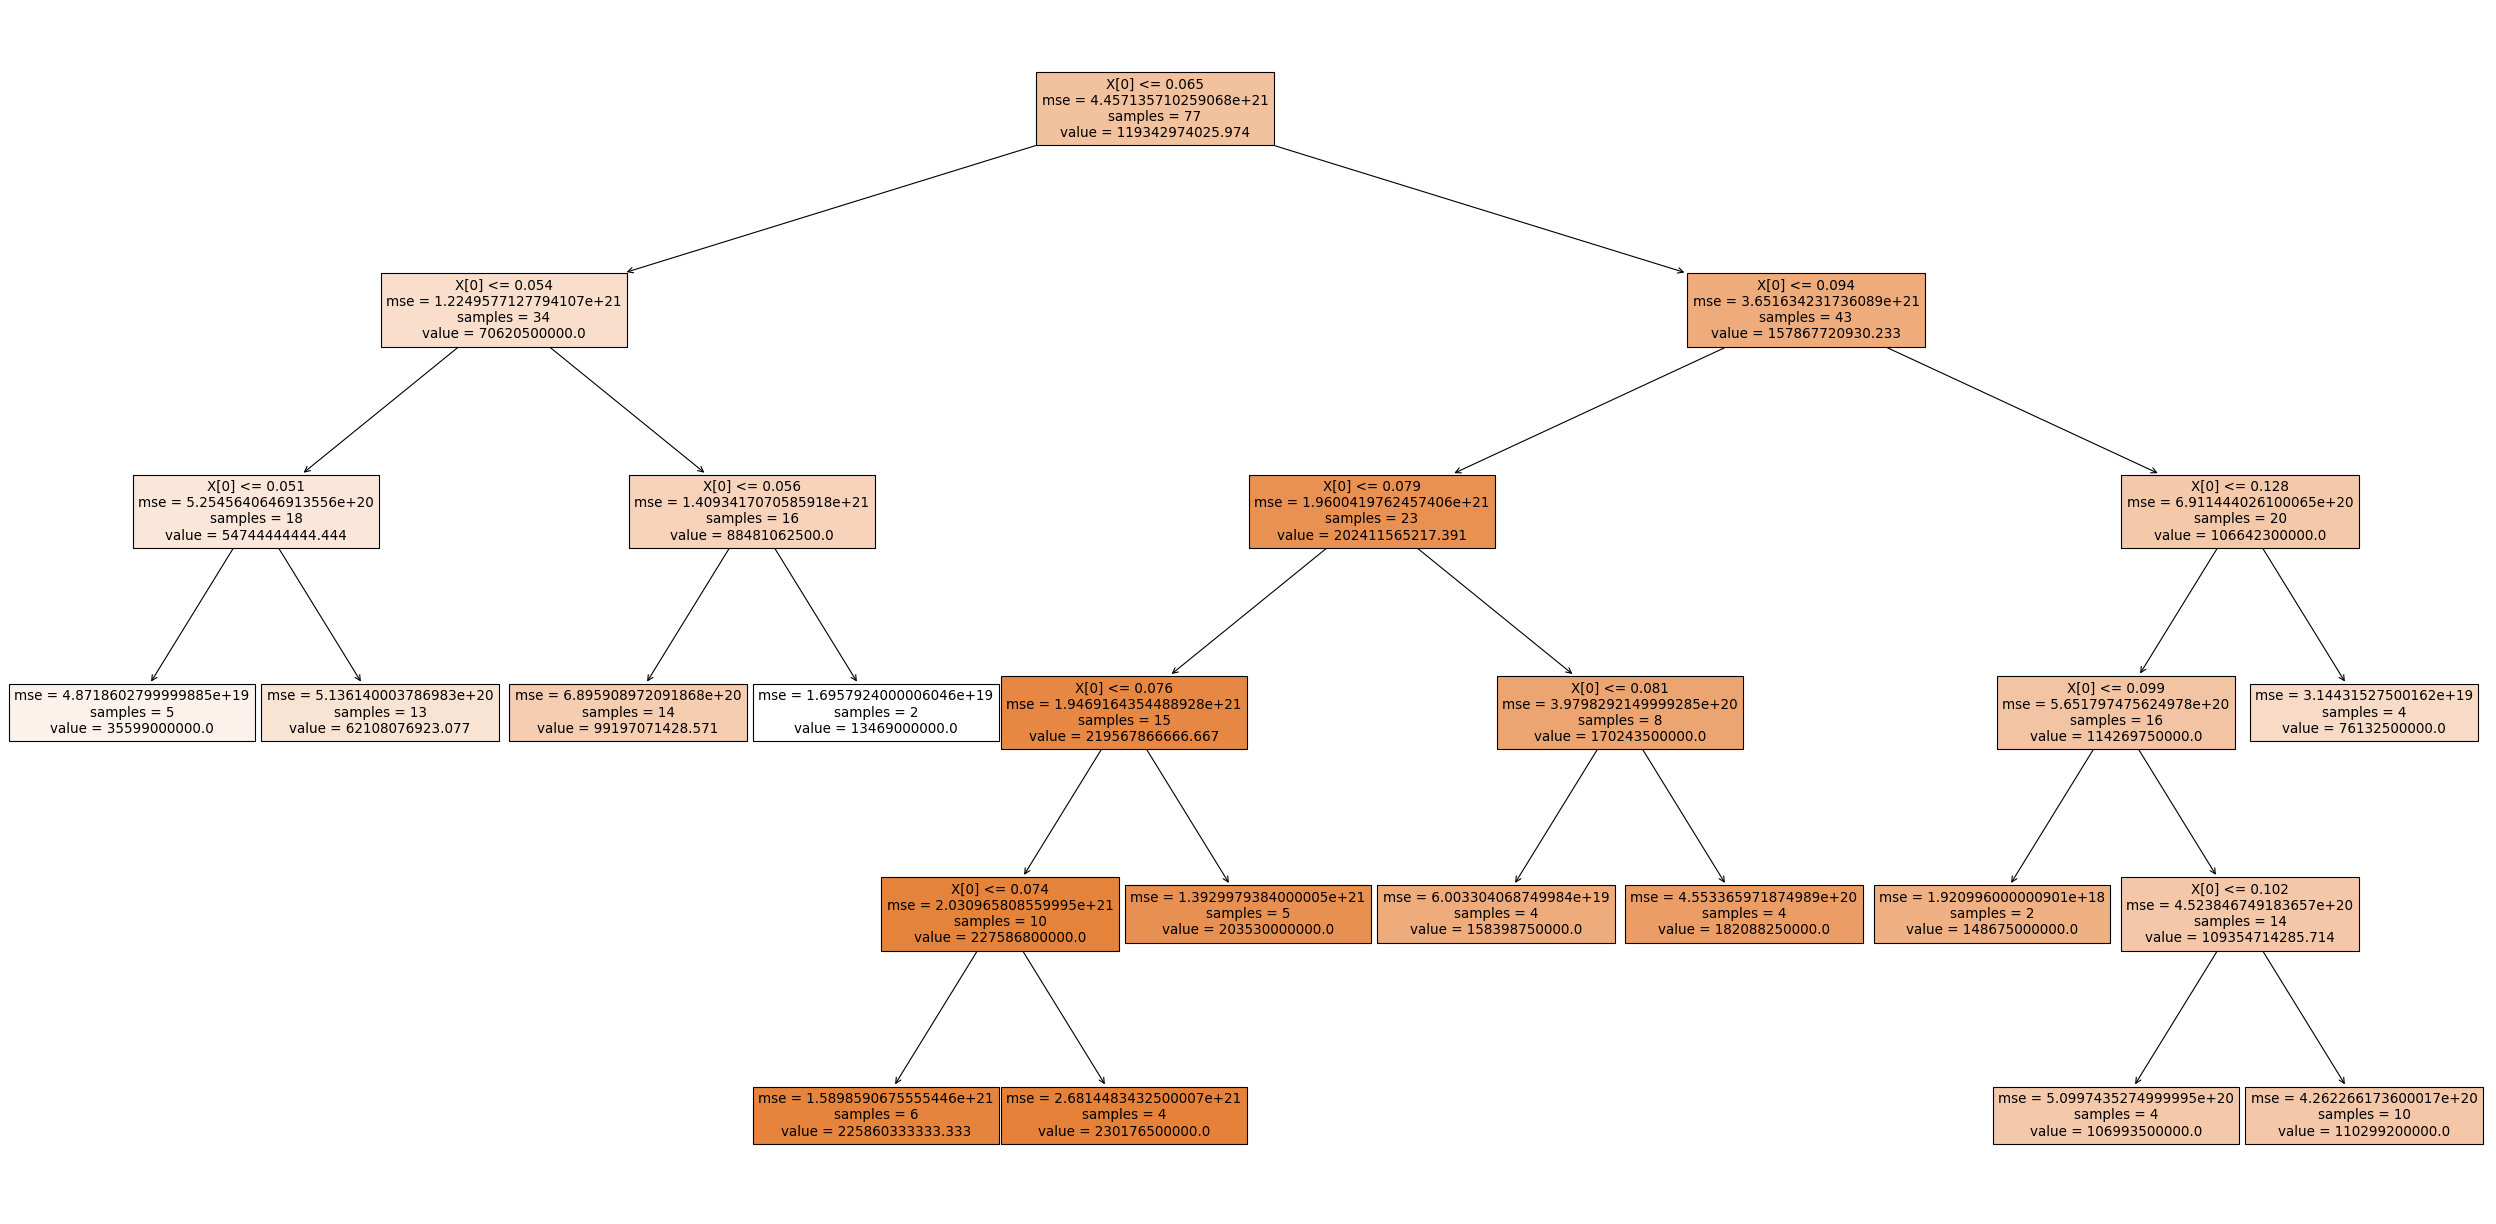

In [44]:
plt.figure(figsize=(40, 20),dpi=80)
plot_tree(model, filled=True)

## Построим лин. регрессию с несколькими независимыми переменными

Алгоритм требует:
- чтобы в данных не было пропусков;
- независимые переменные не должны быть коллинеарными;
- признаки должны быть отмасштабированы.

In [121]:
X = month_factors.drop(['Рынок РФ. Объем выдач рублевых жилищных кредитов', 'Месяц'], axis=1)
knn_imputer = KNNImputer(n_neighbors=5, weights="distance")
X = pd.DataFrame(knn_imputer.fit_transform(X), columns = X.columns)

In [122]:
X = X[:-12]
y = month_factors[['Рынок РФ. Объем выдач рублевых жилищных кредитов']][:-12]

In [123]:
# Удалим все признаки с корреляцией между собой больше 0.7 по модулю
del_col = identify_collinear(X, 0.7)
del_col

['Инфляция (ИПЦ), % гг на конец периода',
 'Денежный агрегат (М0), % гг среднее за период',
 'Рост розничной торговли, %гг (на конец)',
 'Рост розничной торговли, %мм (на конец)',
 'Безработица, % (SA)',
 'Рост M2, %гг',
 'Ключевая ставка ЦБ, % на конец периода',
 'Бескупонная 3-летняя ОФЗ',
 'Бескупонная 5-летняя ОФЗ',
 'Mosprime 3M EOP',
 'Курс руб./$ (рубли за доллар), среднее за период',
 'Курс руб./$ (рубли за доллар), на конец периода',
 'Курс руб./евро, среднее за период',
 'Курс руб./евро, на конец периода',
 'Курс долл./евро (доллар за евро), среднее за период',
 'Номинальная среднемесячная з/п, руб. среднее за период',
 'Профицит/дефицит федерального бюджета (накопленным итогом)',
 'Расходы на национальную оборону (накопленным итогом)',
 'Золотовалютные резервы, млрд. долл. на конец периода']

In [124]:
# заменим 'Ключевая ставка ЦБ, % на конец периода' из del_col на 
# 'Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца'
del_col.remove('Ключевая ставка ЦБ, % на конец периода')
del_col.append('Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. ')

In [125]:
X.drop(del_col, axis = 1, inplace = True)
X.shape

(115, 13)

In [126]:
X_train, X_test, y_train, y_test = custom_split(X=X, y=y, fold_num=20, train_size=0.7)

In [127]:
scaler = RobustScaler()  # используется, если в данных есть выбросы и вы не хотите, чтобы они имели большое влияние

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [128]:
model = LinearRegression()
model, dict_, prediction_tr, prediction = model_train(model, X_train, X_test, y_train, y_test)
pd.DataFrame(dict_)

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,LinearRegression(),"[Инфляция (ИПЦ), % мм на конец периода, Денежн...",13,2.009879e+10,3.989012e+10,2.525083e+10,5.372764e+10,0.857,0.49


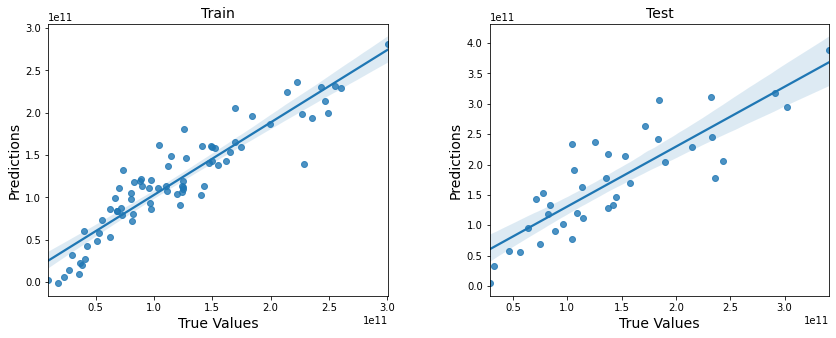

In [129]:
# Графики прогнозов обученной модели
plot_predictions(y_train, y_test, prediction_tr, prediction)

Модель переобучилась: разница между train и test очевидна.

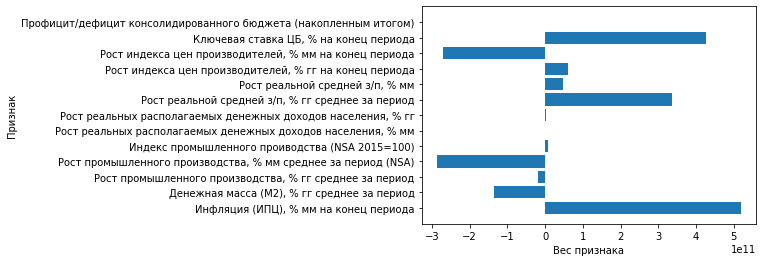

In [130]:
plt.barh(X.columns, model.coef_.flatten())
plt.xlabel("Вес признака")
plt.ylabel("Признак")
plt.show()

In [131]:
df_ = pd.DataFrame(model.coef_.flatten(), X.columns)
df_.reset_index(drop=False, inplace=True)
df_.columns = ['Признак', 'Вес признака']
df_['Вес признака по модулю'] = abs(df_['Вес признака'])
df_.sort_values('Вес признака по модулю', ascending=False , inplace=True)
df_.reset_index(drop=True)

,Признак,Вес признака,Вес признака по модулю
0,"Инфляция (ИПЦ), % мм на конец периода",5.201018e+11,5.201018e+11
1,"Ключевая ставка ЦБ, % на конец периода",4.279871e+11,4.279871e+11
2,"Рост реальной средней з/п, % гг среднее за период",3.353875e+11,3.353875e+11
3,"Рост промышленного производства, % мм среднее ...",-2.874291e+11,2.874291e+11
4,"Рост индекса цен производителей, % мм на конец...",-2.710286e+11,2.710286e+11
5,"Денежная масса (М2), % гг среднее за период",-1.365259e+11,1.365259e+11
6,"Рост индекса цен производителей, % гг на конец...",6.030079e+10,6.030079e+10
7,"Рост реальной средней з/п, % мм",4.782970e+10,4.782970e+10
8,"Рост промышленного производства, % гг среднее ...",-1.790371e+10,1.790371e+10
9,Индекс промышленного проиводства (NSA 2015=100),7.314973e+09,7.314973e+09


Обучим модель на топ-6 фичах:

In [132]:
top_features = df_['Признак'][:6].values.tolist()
top_features

['Инфляция (ИПЦ), % мм на конец периода',
 'Ключевая ставка ЦБ, % на конец периода',
 'Рост реальной средней з/п, % гг среднее за период',
 'Рост промышленного производства, % мм среднее за период (NSA)',
 'Рост индекса цен производителей, % мм на конец периода',
 'Денежная масса (М2), % гг среднее за период']

In [133]:
df_result = pd.DataFrame()

In [134]:
model = LinearRegression()
model, dict_, prediction_tr, prediction = model_train(model, X_train[top_features], X_test[top_features], y_train, y_test)
df_result = df_result.append(pd.DataFrame(dict_))
pd.DataFrame(dict_)

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,LinearRegression(),"[Инфляция (ИПЦ), % мм на конец периода, Ключев...",6,3.164010e+10,4.336952e+10,4.177003e+10,5.827595e+10,0.609,0.4


MAE чуть понизилась, RMSE наоборот чуть выросла. Зато удалось понизить переобучение.

In [135]:
coeff_df = pd.DataFrame(model.coef_.flatten(), top_features)
coeff_df.reset_index(drop=False, inplace=True)
coeff_df.columns = ['Признак', 'Вес признака']
coeff_df

,Признак,Вес признака
0,"Инфляция (ИПЦ), % мм на конец периода",-1.624023e+12
1,"Ключевая ставка ЦБ, % на конец периода",1.355992e+11
2,"Рост реальной средней з/п, % гг среднее за период",5.027001e+11
3,"Рост промышленного производства, % мм среднее ...",1.603405e+11
4,"Рост индекса цен производителей, % мм на конец...",-2.235341e+11
5,"Денежная масса (М2), % гг среднее за период",-5.571792e+11


In [59]:
model.intercept_

array([1.90040948e+11])

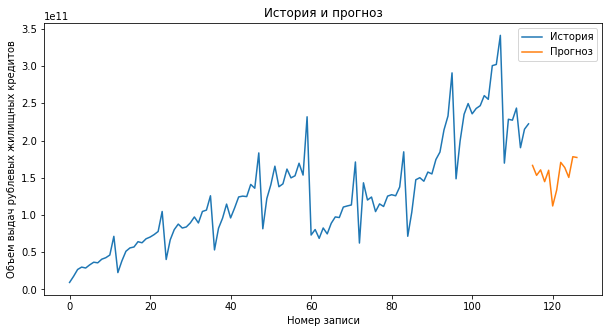

In [61]:
plot_history_future(model, X[top_features], y)

## Заполним пропуски, используя открытые источники данных

Информация по 'Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца' взята с сайта банка России (https://cbr.ru/statistics/bank_sector/mortgage/archiv/)

In [62]:
add_month_factors = pd.read_csv('месячные_доп.csv', ';')

In [63]:
add_month_factors.head(1)

,Unnamed: 0,Рынок РФ. Объем выдач рублевых жилищных кредитов,"Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца.","Инфляция (ИПЦ), % гг на конец периода","Инфляция (ИПЦ), % мм на конец периода","Денежная масса (М2), % гг среднее за период","Денежный агрегат (М0), % гг среднее за период","Рост промышленного производства, % гг среднее за период","Рост промышленного производства, % мм среднее за период (NSA)",Индекс промышленного проиводства (NSA 2015=100),...,"Курс руб./$ (рубли за доллар), среднее за период","Курс руб./$ (рубли за доллар), на конец периода","Курс руб./евро, среднее за период","Курс руб./евро, на конец периода","Курс долл./евро (доллар за евро), среднее за период","Номинальная среднемесячная з/п, руб. среднее за период",Профицит/дефицит консолидированного бюджета (накопленным итогом),Профицит/дефицит федерального бюджета (накопленным итогом),Расходы на национальную оборону (накопленным итогом),"Золотовалютные резервы, млрд. долл. на конец периода"
0,Jan-2010,9.351000e+09,14.17,0.0802,0.0164,0.304,0.169228,0.085,-0.146,77.6,...,29.77,30.36,42.56,42.58,1.4266,18938.0,395.98,87.107,27.12,436.2669


In [64]:
add_month_factors['Ключевая ставка ЦБ, % на конец периода'].\
corr(add_month_factors['Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. '])

0.2504907307658846

In [65]:
add_month_factors['Рынок РФ. Объем выдач рублевых жилищных кредитов'].\
corr(add_month_factors['Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. '])

-0.8004430538564083

Теперь попробуем обучить лин. регрессию, используя 'Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. '

In [66]:
X = add_month_factors.drop(['Рынок РФ. Объем выдач рублевых жилищных кредитов', 'Unnamed: 0'], axis=1)
knn_imputer = KNNImputer(n_neighbors=5, weights="distance")
X = pd.DataFrame(knn_imputer.fit_transform(X), columns = X.columns)

In [67]:
X = X[:-12]
y = add_month_factors[['Рынок РФ. Объем выдач рублевых жилищных кредитов']][:-12]

In [68]:
# Удалим все признаки с корреляцией между собой больше 0.7 по модулю
del_col = identify_collinear(X, 0.7)
del_col

['Инфляция (ИПЦ), % гг на конец периода',
 'Денежный агрегат (М0), % гг среднее за период',
 'Рост розничной торговли, %гг (на конец)',
 'Рост розничной торговли, %мм (на конец)',
 'Рост M2, %гг',
 'Ключевая ставка ЦБ, % на конец периода',
 'Бескупонная 3-летняя ОФЗ',
 'Бескупонная 5-летняя ОФЗ',
 'Mosprime 3M EOP',
 'Курс руб./$ (рубли за доллар), среднее за период',
 'Курс руб./$ (рубли за доллар), на конец периода',
 'Курс руб./евро, среднее за период',
 'Курс руб./евро, на конец периода',
 'Курс долл./евро (доллар за евро), среднее за период',
 'Номинальная среднемесячная з/п, руб. среднее за период',
 'Профицит/дефицит федерального бюджета (накопленным итогом)',
 'Расходы на национальную оборону (накопленным итогом)',
 'Золотовалютные резервы, млрд. долл. на конец периода']

In [69]:
X.drop(del_col, axis = 1, inplace = True)
X.shape

(115, 14)

In [70]:
X_train, X_test, y_train, y_test = custom_split(X=X, y=y, fold_num=20, train_size=0.7)

In [71]:
scaler = RobustScaler()  # используется, если в данных есть выбросы и вы не хотите, чтобы они имели большое влияние

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [74]:
model = LinearRegression()
model, dict_, prediction_tr, prediction = model_train(model, X_train, X_test, y_train, y_test)
df_result = df_result.append(pd.DataFrame(dict_))
pd.DataFrame(dict_)

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,LinearRegression(),[Рынок РФ. Средневзвешенная ставка по жилищным...,14,1.618735e+10,3.250735e+10,1.905187e+10,4.050752e+10,0.919,0.71


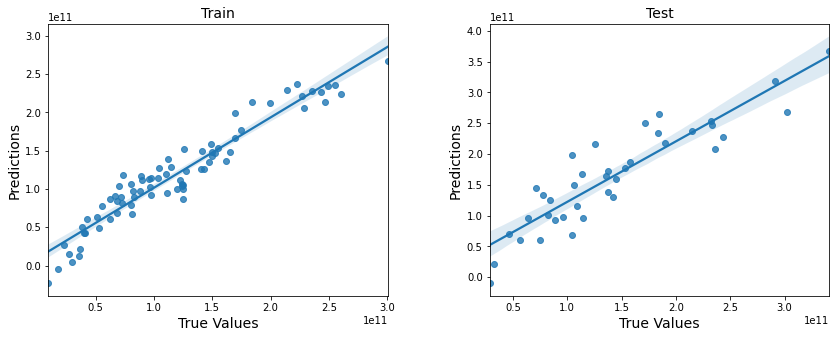

In [75]:
plot_predictions(y_train, y_test, prediction_tr, prediction)

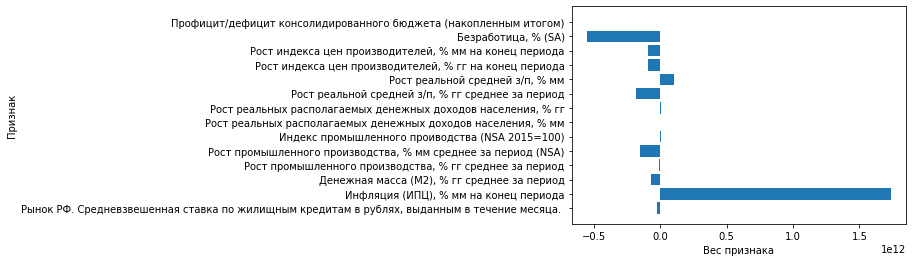

In [76]:
plt.barh(X.columns, model.coef_.flatten())
plt.xlabel("Вес признака")
plt.ylabel("Признак")
plt.show()

In [77]:
df_ = pd.DataFrame(model.coef_.flatten(), X.columns)
df_.reset_index(drop=False, inplace=True)
df_.columns = ['Признак', 'Вес признака']
df_['Вес признака по модулю'] = abs(df_['Вес признака'])
df_.sort_values('Вес признака по модулю', ascending=False , inplace=True)
df_.reset_index(drop=True)

,Признак,Вес признака,Вес признака по модулю
0,"Инфляция (ИПЦ), % мм на конец периода",1.739370e+12,1.739370e+12
1,"Безработица, % (SA)",-5.550086e+11,5.550086e+11
2,"Рост реальной средней з/п, % гг среднее за период",-1.869494e+11,1.869494e+11
3,"Рост промышленного производства, % мм среднее ...",-1.513818e+11,1.513818e+11
4,"Рост реальной средней з/п, % мм",1.046211e+11,1.046211e+11
5,"Рост индекса цен производителей, % мм на конец...",-9.585796e+10,9.585796e+10
6,"Рост индекса цен производителей, % гг на конец...",-9.403552e+10,9.403552e+10
7,"Денежная масса (М2), % гг среднее за период",-6.828981e+10,6.828981e+10
8,Рынок РФ. Средневзвешенная ставка по жилищным ...,-2.918626e+10,2.918626e+10
9,"Рост промышленного производства, % гг среднее ...",-9.828187e+09,9.828187e+09


Обучим модель на топ-5 фичах:

In [78]:
top_features = df_['Признак'][:5].values.tolist()
top_features

['Инфляция (ИПЦ), % мм на конец периода',
 'Безработица, % (SA)',
 'Рост реальной средней з/п, % гг среднее за период',
 'Рост промышленного производства, % мм среднее за период (NSA)',
 'Рост реальной средней з/п, % мм']

In [79]:
model = LinearRegression()
model, dict_, prediction_tr, prediction = model_train(model, X_train[top_features], X_test[top_features], y_train, y_test)
df_result = df_result.append(pd.DataFrame(dict_))
pd.DataFrame(dict_)

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,LinearRegression(),"[Инфляция (ИПЦ), % мм на конец периода, Безраб...",5,2.837926e+10,3.490241e+10,3.698749e+10,4.830400e+10,0.693,0.588


In [80]:
coeff_df = pd.DataFrame(model.coef_.flatten(), top_features)
coeff_df.reset_index(drop=False, inplace=True)
coeff_df.columns = ['Признак', 'Вес признака']
coeff_df

,Признак,Вес признака
0,"Инфляция (ИПЦ), % мм на конец периода",-1.258120e+12
1,"Безработица, % (SA)",-6.110968e+12
2,"Рост реальной средней з/п, % гг среднее за период",1.097016e+11
3,"Рост промышленного производства, % мм среднее ...",7.677644e+10
4,"Рост реальной средней з/п, % мм",6.420561e+10


In [81]:
model.intercept_

array([4.69996215e+11])

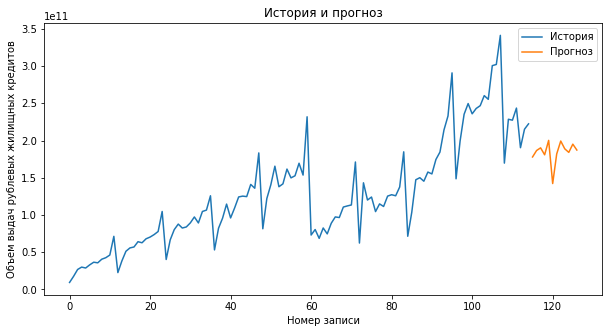

In [83]:
plot_history_future(model, X[top_features], y)

## Построим случайный лес

In [84]:
%%time
rf = RandomForestRegressor()
parametrs = {'max_depth'         : range(1,10),
             'min_samples_split' : range(2,10),
             'min_samples_leaf'  : range(1,10),
             'n_estimators'      : range(10, 101, 10)}
search = RandomizedSearchCV(rf, parametrs, n_iter=20)

search.fit(X, y)

Wall time: 5.17 s


RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': range(1, 10),
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': range(10, 101, 10)})

In [85]:
search.best_params_

{'n_estimators': 10,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_depth': 9}

In [86]:
model = RandomForestRegressor(**search.best_params_, random_state=1)
model, dict_, prediction_tr, prediction = model_train(model, X_train, X_test, y_train, y_test)
df_result = df_result.append(pd.DataFrame(dict_))
pd.DataFrame(dict_)

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,"(DecisionTreeRegressor(max_depth=9, max_featur...",[Рынок РФ. Средневзвешенная ставка по жилищным...,14,8.694568e+09,2.383673e+10,1.241806e+10,3.704143e+10,0.965,0.758


In [87]:
df_ = pd.DataFrame(model.feature_importances_, X.columns)
df_.reset_index(drop=False, inplace=True)
df_.columns = ['Признак', 'Вес признака']
df_.sort_values('Вес признака', ascending=False , inplace=True)
df_.reset_index(drop=True)

,Признак,Вес признака
0,"Безработица, % (SA)",0.369660
1,Рынок РФ. Средневзвешенная ставка по жилищным ...,0.318950
2,Индекс промышленного проиводства (NSA 2015=100),0.136920
3,"Денежная масса (М2), % гг среднее за период",0.091760
4,Профицит/дефицит консолидированного бюджета (н...,0.030581
5,"Рост индекса цен производителей, % гг на конец...",0.014102
6,Рост реальных располагаемых денежных доходов н...,0.009850
7,"Рост реальной средней з/п, % мм",0.007731
8,"Рост индекса цен производителей, % мм на конец...",0.006007
9,Рост реальных располагаемых денежных доходов н...,0.005145


In [88]:
top_features = df_['Признак'][:4].values.tolist()
top_features

['Безработица, % (SA)',
 'Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. ',
 'Индекс промышленного проиводства (NSA 2015=100)',
 'Денежная масса (М2), % гг среднее за период']

In [89]:
%%time
search.fit(X[top_features], y)

Wall time: 4.41 s


RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': range(1, 10),
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': range(10, 101, 10)})

In [90]:
search.best_params_

{'n_estimators': 60,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 7}

In [91]:
model = RandomForestRegressor(**search.best_params_, random_state=1)
model, dict_, prediction_tr, prediction = model_train(model, X_train[top_features], X_test[top_features], y_train, y_test)
df_result = df_result.append(pd.DataFrame(dict_))
pd.DataFrame(dict_)

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,"(DecisionTreeRegressor(max_depth=7, max_featur...","[Безработица, % (SA), Рынок РФ. Средневзвешенн...",4,8.365842e+09,2.129785e+10,1.152876e+10,3.158619e+10,0.97,0.824


Все хорошо, но мне не нравится большой R2 на трейне.

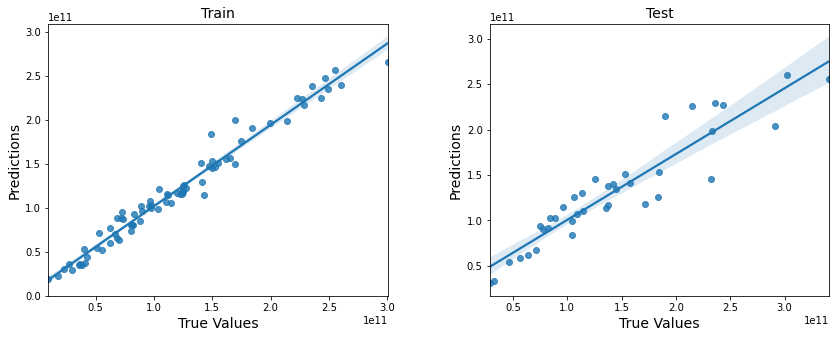

In [92]:
plot_predictions(y_train, y_test, prediction_tr, prediction)

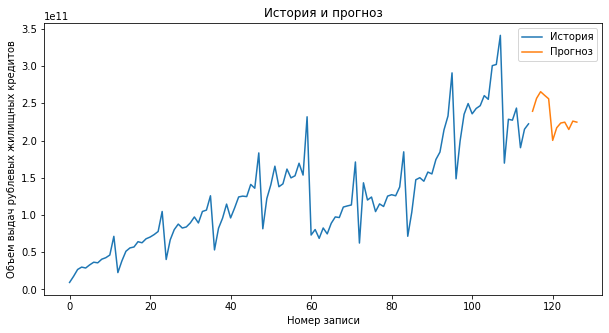

In [93]:
plot_history_future(model, X[top_features], y)

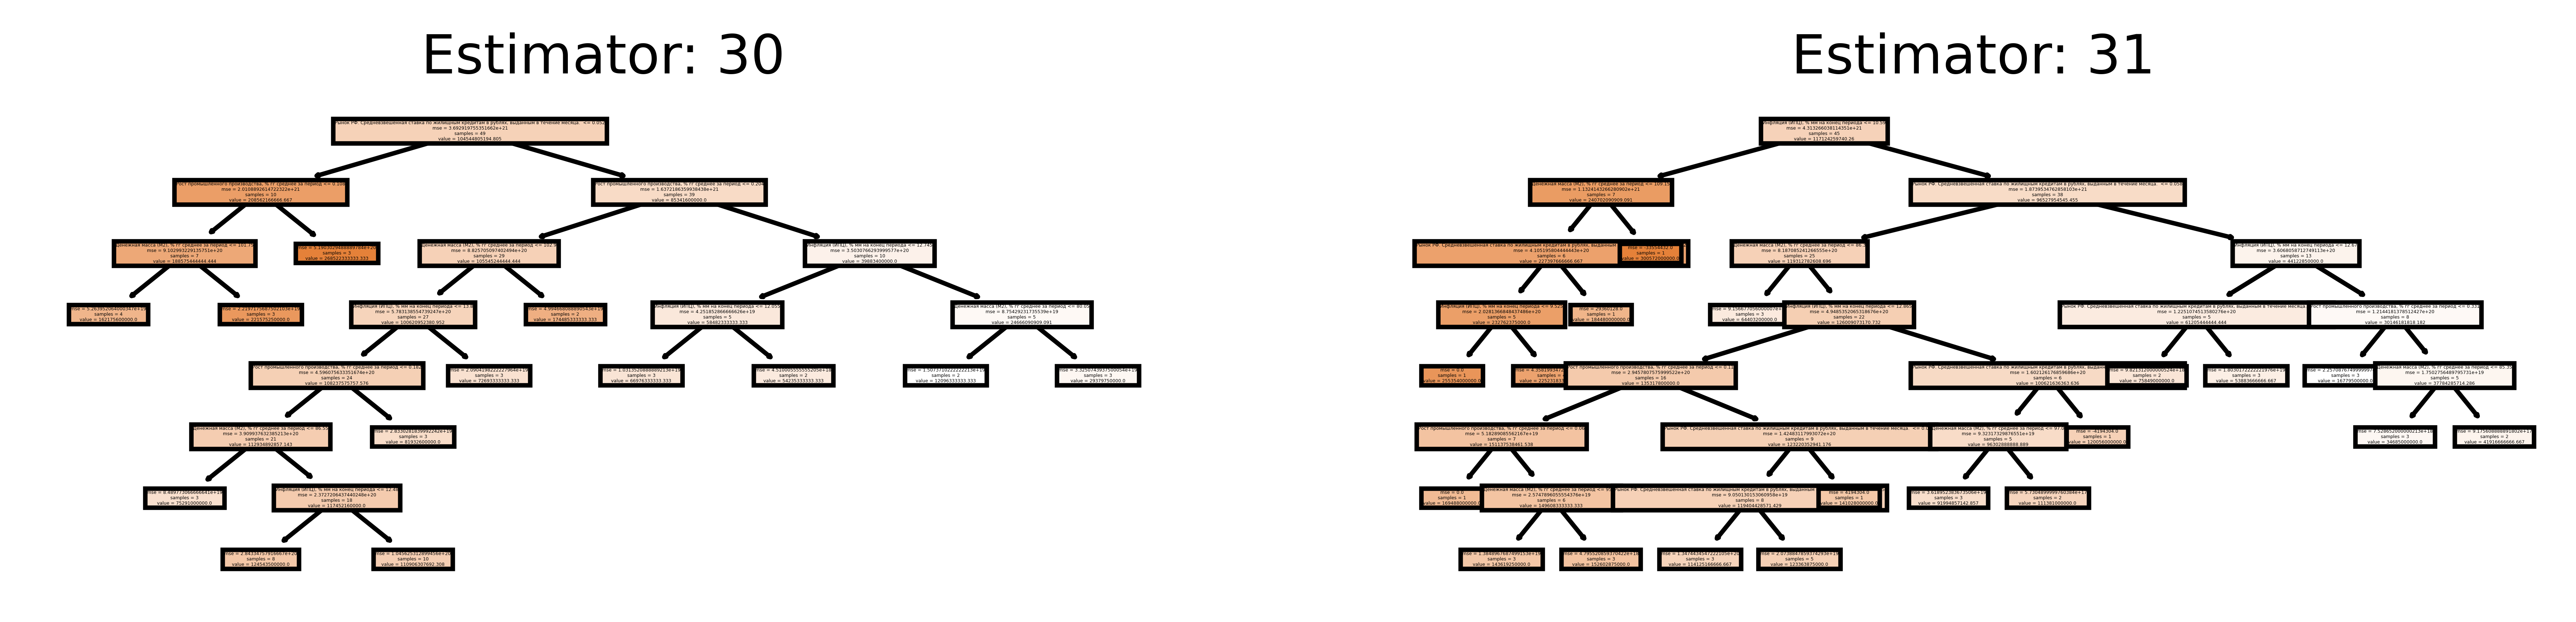

In [94]:
# Демонстрационный вариант интерпретации деревьев
fn = X.columns.to_series().values
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,2), dpi=900)
for index in range(30, 32):
    plot_tree(model.estimators_[index],
              feature_names=fn, 
              filled=True,
              impurity=True,
              ax=axes[index-30]);

    axes[index-30].set_title('Estimator: ' + str(index))

## Построим градиентный бустинг

In [95]:
%%time
search = GridSearchCV(estimator = CatBoostRegressor(random_state=1, silent=True),
                      param_grid = {'iterations'    : range(1, 13, 2), 
                                    'learning_rate' : np.linspace(0.01, 0.9, 10),
                                    'depth'         : range(1, 13, 2)})
search.fit(X, y)

Wall time: 2min 5s


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x000002394F84D790>,
             param_grid={'depth': range(1, 13, 2),
                         'iterations': range(1, 13, 2),
                         'learning_rate': array([0.01      , 0.10888889, 0.20777778, 0.30666667, 0.40555556,
       0.50444444, 0.60333333, 0.70222222, 0.80111111, 0.9       ])})

In [96]:
search.best_params_

{'depth': 3, 'iterations': 11, 'learning_rate': 0.7022222222222222}

In [97]:
model = CatBoostRegressor(**search.best_params_, random_state=1, silent=True)
model, dict_, prediction_tr, prediction = model_train(model, X_train, X_test, y_train, y_test)
df_result = df_result.append(pd.DataFrame(dict_))
pd.DataFrame(dict_)

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,<catboost.core.CatBoostRegressor object at 0x0...,[Рынок РФ. Средневзвешенная ставка по жилищным...,14,8.243189e+09,2.680965e+10,1.045808e+10,3.591473e+10,0.975,0.772


In [98]:
df_ = pd.DataFrame(model.feature_importances_, X.columns)
df_.reset_index(drop=False, inplace=True)
df_.columns = ['Признак', 'Вес признака']
df_.sort_values('Вес признака', ascending=False , inplace=True)
df_.reset_index(drop=True)

,Признак,Вес признака
0,Рынок РФ. Средневзвешенная ставка по жилищным ...,50.979440
1,"Денежная масса (М2), % гг среднее за период",12.770930
2,Индекс промышленного проиводства (NSA 2015=100),11.622324
3,"Инфляция (ИПЦ), % мм на конец периода",4.989630
4,Профицит/дефицит консолидированного бюджета (н...,4.967760
5,"Рост индекса цен производителей, % гг на конец...",4.617873
6,"Безработица, % (SA)",2.707845
7,"Рост промышленного производства, % мм среднее ...",2.394040
8,Рост реальных располагаемых денежных доходов н...,2.141108
9,Рост реальных располагаемых денежных доходов н...,1.571721


In [99]:
top_features = df_['Признак'][:3].values.tolist()
top_features

['Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. ',
 'Денежная масса (М2), % гг среднее за период',
 'Индекс промышленного проиводства (NSA 2015=100)']

In [103]:
%%time
search = GridSearchCV(estimator = CatBoostRegressor(random_state=1, silent=True),
                      param_grid = {'iterations'    : range(1, 13, 2), 
                                    'learning_rate' : np.linspace(0.01, 0.9, 10),
                                    'depth'         : range(1, 13, 2),
                                    'l2_leaf_reg'   : range(5, 25, 5)})
search.fit(X[top_features], y)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Wall time: 6min 36s


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x0000023955028910>,
             param_grid={'depth': range(1, 13, 2),
                         'iterations': range(1, 13, 2),
                         'l2_leaf_reg': range(5, 25, 5),
                         'learning_rate': array([0.01      , 0.10888889, 0.20777778, 0.30666667, 0.40555556,
       0.50444444, 0.60333333, 0.70222222, 0.80111111, 0.9       ])})

In [104]:
search.best_params_

{'depth': 5, 'iterations': 11, 'l2_leaf_reg': 5, 'learning_rate': 0.9}

In [105]:
model = CatBoostRegressor(**search.best_params_, random_state=1, silent=True)
model, dict_, prediction_tr, prediction = model_train(model, X_train[top_features], X_test[top_features], y_train, y_test)
df_result = df_result.append(pd.DataFrame(dict_))
pd.DataFrame(dict_)

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,<catboost.core.CatBoostRegressor object at 0x0...,[Рынок РФ. Средневзвешенная ставка по жилищным...,3,9.478513e+09,1.918126e+10,1.237598e+10,2.783323e+10,0.966,0.863


Посмотрим на итерпретацию модели:

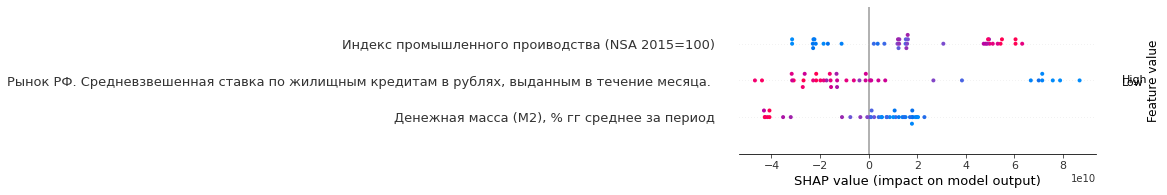

In [106]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[top_features], y_test)
shap.summary_plot(shap_values, X_test[top_features])

К увеличению выдачи кредитов приводит:
- маленькие значения ставки и %-ты денежной массы (синие точки);
- большие значения индекса пром. произ-ва (красные точки).

Что потверждают знаки корреляций этих фичей с целевой переменной. 

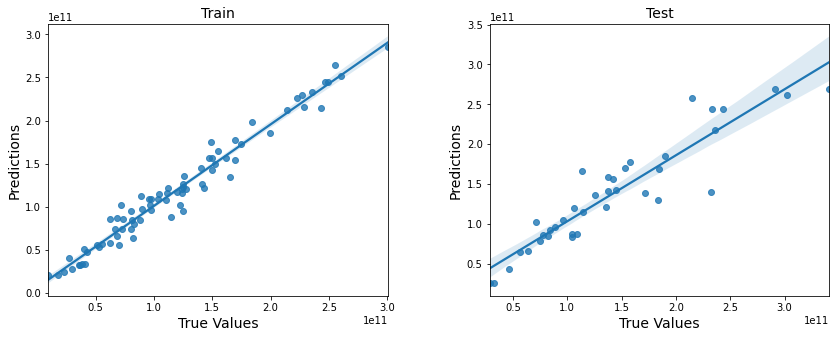

In [107]:
# Графики прогнозов обученной модели
plot_predictions(y_train, y_test, prediction_tr, prediction)

## Cамая лучшая модель

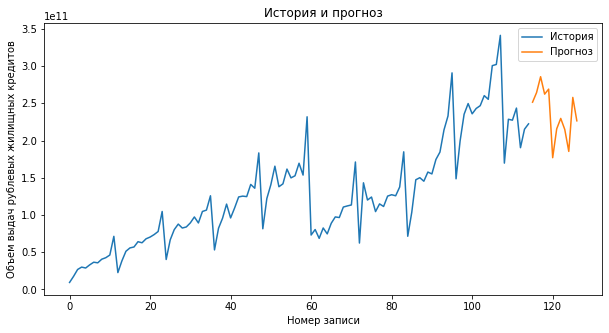

In [108]:
plot_history_future(model, X[top_features], y)

## Построим модели по одной ставке

In [109]:
X = add_month_factors[['Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. ']][:-12]
y = add_month_factors[['Рынок РФ. Объем выдач рублевых жилищных кредитов']][:-12]

In [110]:
X_train, X_test, y_train, y_test = custom_split(X=X, y=y, fold_num=20, train_size=0.7)

In [111]:
scaler = RobustScaler()  # используется, если в данных есть выбросы и вы не хотите, чтобы они имели большое влияние

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [112]:
model = LinearRegression()
model, dict_, prediction_tr, prediction = model_train(model, X_train_scaled, X_test_scaled, y_train, y_test)
df_result = df_result.append(pd.DataFrame(dict_))
pd.DataFrame(dict_)

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,LinearRegression(),[Рынок РФ. Средневзвешенная ставка по жилищным...,1,3.403140e+10,4.046796e+10,3.922959e+10,5.278011e+10,0.655,0.508


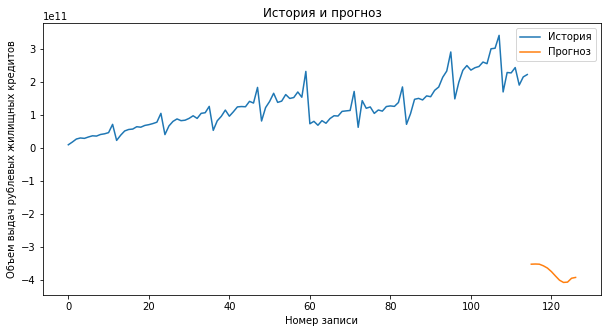

In [113]:
plot_history_future(model, X, y)

In [116]:
%%time
search = GridSearchCV(estimator = CatBoostRegressor(random_state=1, silent=True),
                      param_grid = {'iterations'    : range(1, 13, 2), 
                                    'learning_rate' : np.linspace(0.01, 0.9, 10),
                                    'depth'         : range(1, 13, 2),
                                    'l2_leaf_reg'   : range(5, 25, 5)})
search.fit(X, y)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Wall time: 6min 27s


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x0000023956FB5760>,
             param_grid={'depth': range(1, 13, 2),
                         'iterations': range(1, 13, 2),
                         'l2_leaf_reg': range(5, 25, 5),
                         'learning_rate': array([0.01      , 0.10888889, 0.20777778, 0.30666667, 0.40555556,
       0.50444444, 0.60333333, 0.70222222, 0.80111111, 0.9       ])})

In [117]:
search.best_params_

{'depth': 3, 'iterations': 7, 'l2_leaf_reg': 5, 'learning_rate': 0.9}

In [118]:
model = CatBoostRegressor(**search.best_params_, random_state=1, silent=True)
model, dict_, prediction_tr, prediction = model_train(model, X_train, X_test, y_train, y_test)
df_result = df_result.append(pd.DataFrame(dict_))
pd.DataFrame(dict_)

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,<catboost.core.CatBoostRegressor object at 0x0...,[Рынок РФ. Средневзвешенная ставка по жилищным...,1,2.585270e+10,3.603706e+10,3.091673e+10,4.793206e+10,0.786,0.594


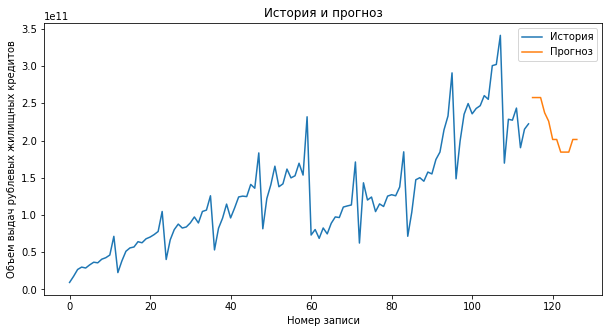

In [119]:
plot_history_future(model, X, y)

Модели получились более переобученными и менее точными, чем с несколькими фичами. Ч.т.д.

In [140]:
df_result = df_result.sort_values(['MAE test','RMSE test'], ascending=[True, True])
df_result.reset_index(drop=True, inplace=True)

In [141]:
df_result

,regressor,features,features num,MAE train,MAE test,RMSE train,RMSE test,R2 train,R2 test
0,<catboost.core.CatBoostRegressor object at 0x0...,[Рынок РФ. Средневзвешенная ставка по жилищным...,3,9.478513e+09,1.918126e+10,1.237598e+10,2.783323e+10,0.966,0.863
1,"(DecisionTreeRegressor(max_depth=7, max_featur...","[Безработица, % (SA), Рынок РФ. Средневзвешенн...",4,8.365842e+09,2.129785e+10,1.152876e+10,3.158619e+10,0.970,0.824
2,"(DecisionTreeRegressor(max_depth=9, max_featur...",[Рынок РФ. Средневзвешенная ставка по жилищным...,14,8.694568e+09,2.383673e+10,1.241806e+10,3.704143e+10,0.965,0.758
3,<catboost.core.CatBoostRegressor object at 0x0...,[Рынок РФ. Средневзвешенная ставка по жилищным...,14,8.243189e+09,2.680965e+10,1.045808e+10,3.591473e+10,0.975,0.772
4,LinearRegression(),[Рынок РФ. Средневзвешенная ставка по жилищным...,14,1.618735e+10,3.250735e+10,1.905187e+10,4.050752e+10,0.919,0.710
5,LinearRegression(),"[Инфляция (ИПЦ), % мм на конец периода, Безраб...",5,2.837926e+10,3.490241e+10,3.698749e+10,4.830400e+10,0.693,0.588
6,<catboost.core.CatBoostRegressor object at 0x0...,[Рынок РФ. Средневзвешенная ставка по жилищным...,1,2.585270e+10,3.603706e+10,3.091673e+10,4.793206e+10,0.786,0.594
7,LinearRegression(),[Рынок РФ. Средневзвешенная ставка по жилищным...,1,3.403140e+10,4.046796e+10,3.922959e+10,5.278011e+10,0.655,0.508
8,LinearRegression(),"[Инфляция (ИПЦ), % мм на конец периода, Ключев...",6,3.164010e+10,4.336952e+10,4.177003e+10,5.827595e+10,0.609,0.400


In [142]:
df_result.features[0]

['Рынок РФ. Средневзвешенная ставка по жилищным кредитам в рублях, выданным в течение месяца. ',
 'Денежная масса (М2), % гг среднее за период',
 'Индекс промышленного проиводства (NSA 2015=100)']